# Image Neuropixel Classification Project
The purpose of this program is to classify images based on the firing rates of a set of neurons. The data that will be used is from the Ecephys Project. Each neuron, referred to as a unit here, has already been processed.\

1. Load ecephys data and pull necessary datasets.
2. Use a t-SNE model for classification.
3. Use a Convolutional Neural Network for classification.
4. Use different regressions for prediction and possibly further inference.\

I want to understand the network of neurons that are firing unique to each image. I want to see if the firing rates of each neuron is enough information to classify what the mouse is looking at.



In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
# Show all columns
pd.set_option('display.max_columns', None)

In [2]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


GPU is available


In [3]:
### Open the entire dataset.
# Set output directory to '/local1/ecephys_cache_dir'
output_dir = '/local1/ecephys_cache_dir' # must be updated to a valid directory in your filesystem
# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True
# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")
# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)

In [4]:
# Pick specific session.
session = cache.get_session_data(719161530,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'structurewise_unit_c

### Look at the visual stimulus presented for the session.

In [5]:
# Display objects within session.
print('Visual Stimulus for session', session.ecephys_session_id)
pd.unique(session.stimulus_presentations['stimulus_name'])

Visual Stimulus for session 719161530


array(['spontaneous', 'gabors', 'invalid_presentation', 'flashes',
       'drifting_gratings', 'natural_movie_three', 'natural_movie_one',
       'static_gratings', 'natural_scenes'], dtype=object)

In [6]:
# Choose the natural scenes portion of the dataset.
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name'] == 'natural_scenes']
np.sort(pd.unique(natural_scenes['frame']))
natural_scenes

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
51353,null,null,34.0,null,null,null,null,5908.739537,9.0,natural_scenes,5908.989739,null,null,null,0.250201,4908.0
51354,null,null,6.0,null,null,null,null,5908.989739,9.0,natural_scenes,5909.239940,null,null,null,0.250201,4909.0
51355,null,null,28.0,null,null,null,null,5909.239940,9.0,natural_scenes,5909.490142,null,null,null,0.250201,4910.0
51356,null,null,109.0,null,null,null,null,5909.490142,9.0,natural_scenes,5909.740343,null,null,null,0.250201,4911.0
51357,null,null,105.0,null,null,null,null,5909.740343,9.0,natural_scenes,5909.990554,null,null,null,0.250211,4912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68222,null,null,5.0,null,null,null,null,8567.259561,13.0,natural_scenes,8567.509775,null,null,null,0.250214,4980.0
68223,null,null,94.0,null,null,null,null,8567.509775,13.0,natural_scenes,8567.759989,null,null,null,0.250214,4964.0
68224,null,null,17.0,null,null,null,null,8567.759989,13.0,natural_scenes,8568.010203,null,null,null,0.250214,4957.0


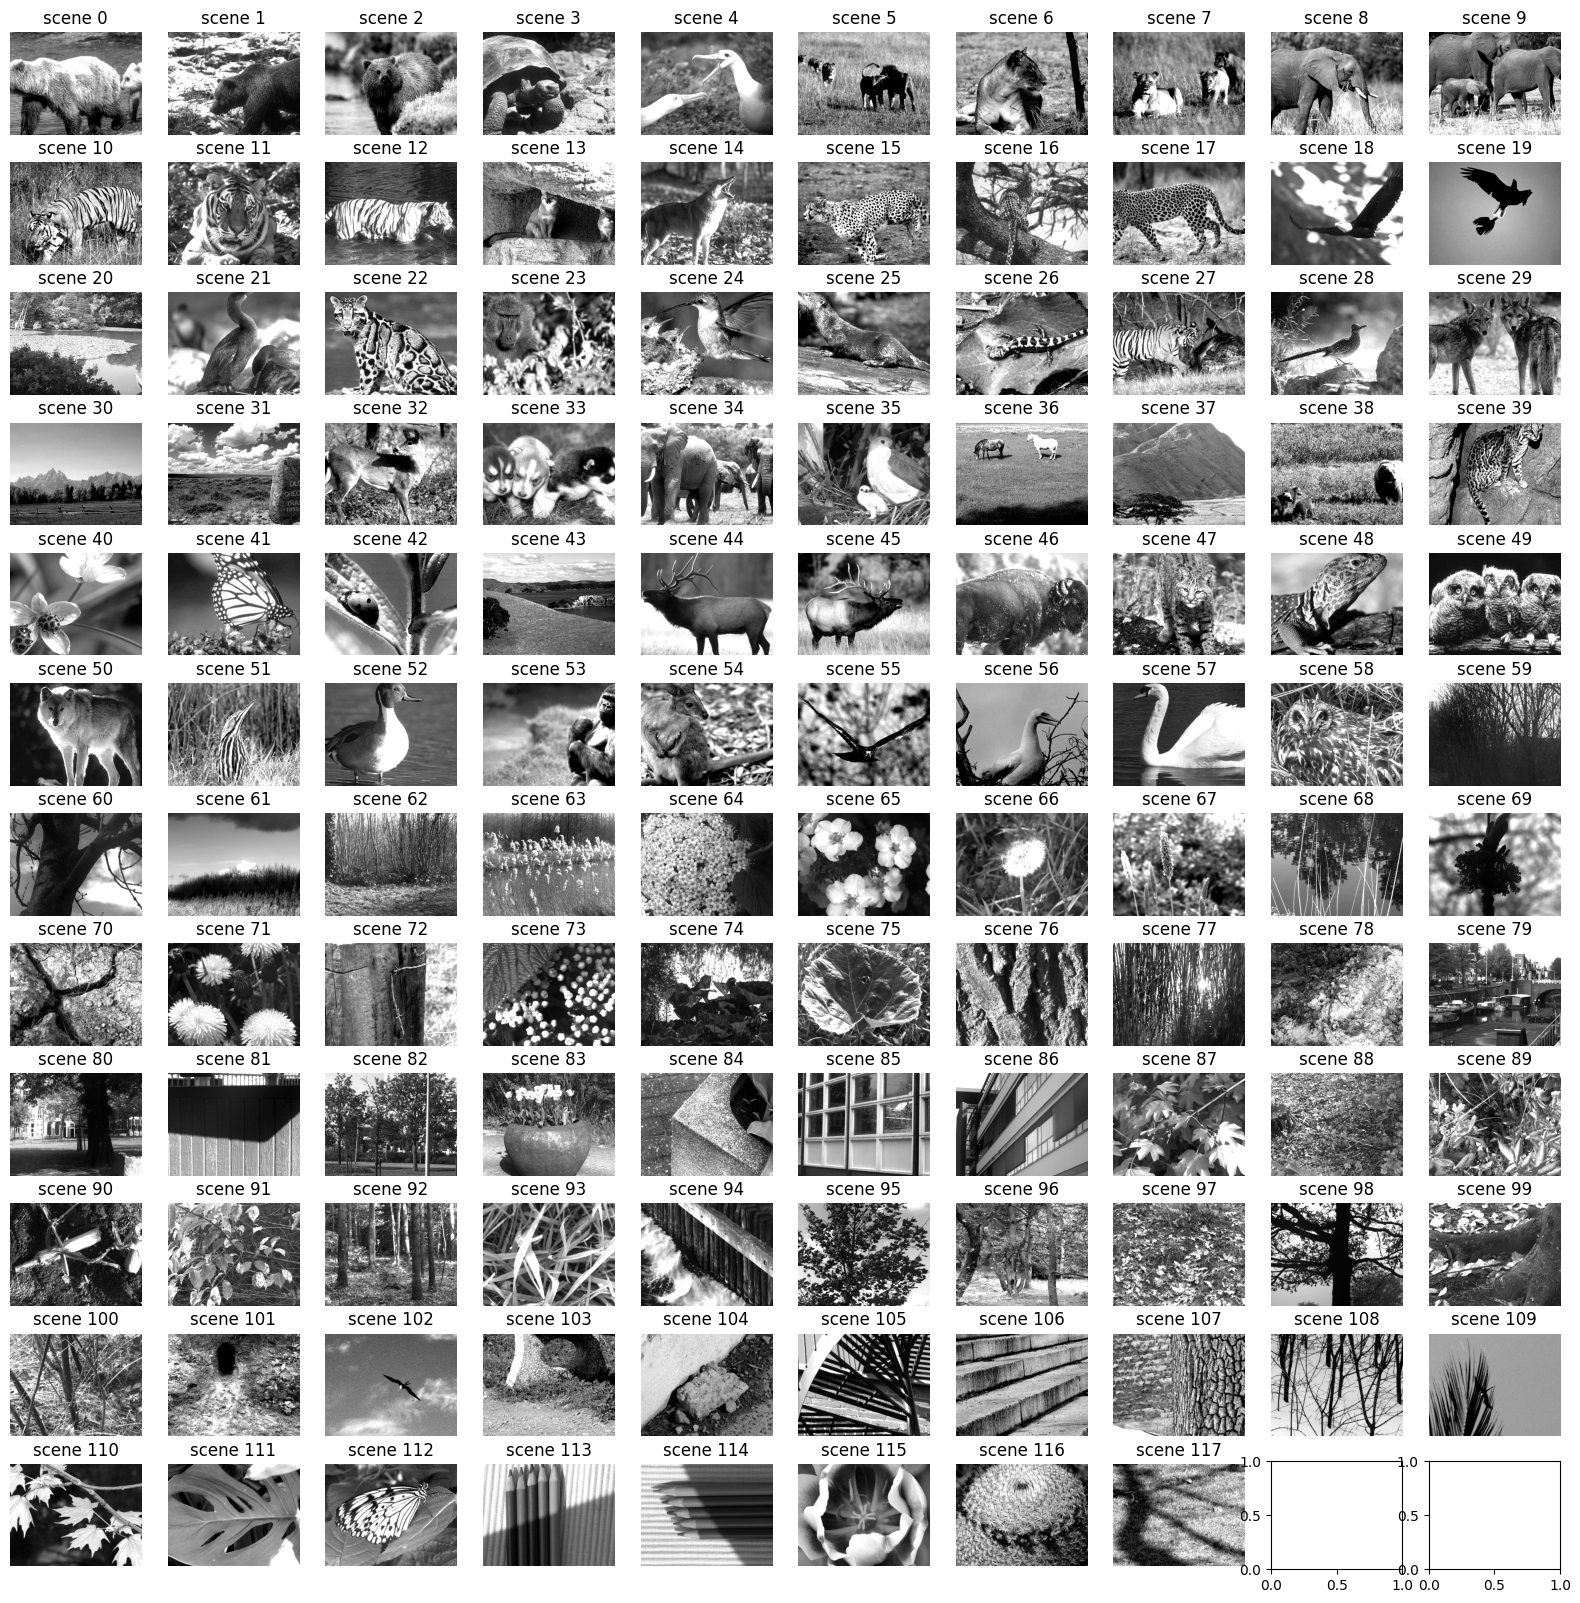

In [7]:
# Pull from where images are located.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# Show all scenes.
scene_nums = np.arange(0)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

try:
    fig, axes = plt.subplots(12, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(scenes[i], cmap='gray')
        ax.set_axis_off()
        ax.set_title('scene %d' % i)
except IndexError:
    pass # ignore the IndexError and continue running the code


### Calculate average firing rates

In [8]:
spike_times = session.spike_times

In [9]:
'''
# Extract the unique frames (images).
unique_frames = stimulus_table['frame'].unique()

# Calculate the average firing rate for each neuron per image.
avg_firing_rates = []

# Iterate through each neuron is it's spike times.
for neuron, spike_times_neuron in spike_times.items():
    # Store all average firing rate for all times an image is shown to a neuron.
    neuron_firing_rates = []
    
    # Iterate through each frame.
    for frame in unique_frames:
        # Find all the start and stop time for 
        stimulus_start = stimulus_table.loc[stimulus_table['frame'] == frame, 'start_time'].values
        stimulus_end = stimulus_table.loc[stimulus_table['frame'] == frame, 'stop_time'].values
        
        # Calculate the spike counts for each scene.
        spike_counts = []
        for start, end in zip(stimulus_start, stimulus_end):
            # Use tensorflow to find the spike counts inbetween each time.
            spikes_in_range = tf.reduce_sum(tf.cast(tf.math.logical_and(spike_times_neuron >= start, spike_times_neuron <= end), tf.float32))
            spike_counts.append(spikes_in_range.numpy())
        
        # Find the average spike count for a single time a frame is shown to a neuron.
        mean_spike_count = np.mean(spike_counts)
        neuron_firing_rates.append(mean_spike_count / (end - start))
    
    avg_firing_rates.append(neuron_firing_rates)

# Convert the results into a pandas DataFrame
avg_firing_rates_df = pd.DataFrame(avg_firing_rates, columns=unique_frames)
'''

"\n# Extract the unique frames (images).\nunique_frames = stimulus_table['frame'].unique()\n\n# Calculate the average firing rate for each neuron per image.\navg_firing_rates = []\n\n# Iterate through each neuron is it's spike times.\nfor neuron, spike_times_neuron in spike_times.items():\n    # Store all average firing rate for all times an image is shown to a neuron.\n    neuron_firing_rates = []\n    \n    # Iterate through each frame.\n    for frame in unique_frames:\n        # Find all the start and stop time for \n        stimulus_start = stimulus_table.loc[stimulus_table['frame'] == frame, 'start_time'].values\n        stimulus_end = stimulus_table.loc[stimulus_table['frame'] == frame, 'stop_time'].values\n        \n        # Calculate the spike counts for each scene.\n        spike_counts = []\n        for start, end in zip(stimulus_start, stimulus_end):\n            # Use tensorflow to find the spike counts inbetween each time.\n            spikes_in_range = tf.reduce_sum(tf.c

In [93]:
avg_firing_rates_df = pd.read_csv('avg_firing_rates_natural_scense.csv')
# 117 images and two white screens.
avg_firing_rates_df.columns = [str(i) for i in range(1, 120)]
np.shape(avg_firing_rates_df)
avg_firing_rates_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
0,15.187481,15.507218,16.146344,15.666773,15.506576,16.386329,18.144499,16.626295,20.782661,14.707709,16.786666,17.745550,16.146344,16.786834,15.427107,15.107547,15.507528,14.947209,16.785635,16.945354,15.987438,15.586507,15.347020,15.747178,15.506886,17.825459,15.107245,15.746706,15.746368,18.224431,16.546833,16.465745,15.427107,15.746863,14.868169,15.666773,15.746998,16.386165,14.867426,16.786498,17.984996,14.707562,17.585154,15.426667,15.267546,14.467785,14.947807,17.584978,15.906389,17.185295,17.664910,17.106243,17.105192,14.947060,15.907047,15.347940,16.945498,15.906729,16.626105,17.745373,15.586529,17.345703,15.747178,14.707877,15.507218,17.425811,16.306209,16.705871,15.906571,17.424915,15.267241,17.505721,15.506731,15.906389,16.705895,14.787642,16.546030,16.146506,15.746840,15.107547,17.025772,15.587152,15.427437,13.668850,13.907960,15.106469,16.705728,15.666773,15.188088,18.144862,15.826796,15.827406,17.025772,15.746840,16.386984,15.586974,15.507063,14.787811,17.025262,15.906888,16.946176,15.906729,18.544528,17.105388,14.388140,15.986503,15.187004,18.704928,14.947060,15.826931,15.986160,14.308614,14.147772,16.066091,16.785827,15.906729,15.746706,15.826954,18.544714
1,1.358880,0.319736,0.399662,0.559528,1.198962,0.799333,0.399659,0.479605,1.758533,0.559532,0.959238,1.438828,0.319730,0.559561,0.959198,1.199012,0.879293,0.479590,1.358837,1.198964,0.239812,0.959170,0.639459,1.358894,0.559527,1.598696,0.719393,0.959190,0.239792,1.198976,0.639491,0.639446,0.479599,0.639466,0.639491,0.399663,0.159868,0.799325,0.719392,1.278971,0.879266,0.959189,0.319730,1.518687,0.559544,0.479595,0.559544,0.719385,1.358837,1.438769,0.959181,0.319743,1.518685,0.239792,0.559544,1.199058,1.119042,0.959200,0.479599,0.479605,0.639447,0.399671,0.479609,0.879275,0.719407,0.639479,0.479594,1.358851,1.039123,0.639446,1.358864,0.959218,0.719384,1.119042,0.399663,0.399666,0.159865,0.879265,0.319733,0.959209,0.959198,1.678616,1.278959,0.559544,0.639446,0.559499,0.639454,0.799325,0.639498,0.639466,0.719400,1.358919,0.719399,0.479599,0.399683,0.559532,0.719400,0.000000,1.358824,1.918419,2.717783,0.959200,1.278933,1.039112,1.039143,2.158178,0.719384,0.719420,1.358824,1.199010,1.438754,0.559555,0.479585,0.879239,0.479595,0.559533,0.239798,0.479605,0.319736
2,4.955915,4.236508,2.957499,3.117368,3.756748,3.756866,3.676859,3.756903,4.556199,4.476259,5.195873,6.154988,3.517026,4.076803,4.316393,4.236508,3.677043,2.637743,5.435349,4.476131,4.076797,3.596886,4.476214,3.677006,4.476214,5.595436,4.076558,4.156491,3.357094,4.156449,3.916883,3.516955,3.197328,3.517066,3.437265,4.076558,2.398020,5.675208,5.914998,5.515564,5.195665,4.476214,4.556153,3.996546,4.396414,4.795951,3.677001,3.916654,4.236375,3.516990,2.717678,3.916850,2.238062,3.836678,5.915183,3.757048,4.556101,4.875932,4.396326,4.556244,2.397928,5.115783,3.517136,3.517101,2.477957,4.556290,4.556147,4.156485,3.357166,4.795848,4.556192,4.316479,3.916649,3.117332,5.195613,3.437128,4.316356,4.875925,2.318063,4.156574,3.197328,4.716112,3.197396,2.717783,4.795848,2.477781,4.636039,4.716018,2.478057,4.636132,4.076599,3.677074,5.115725,3.836793,3.357333,3.996660,4.955865,4.236508,4.236332,4.076640,3.996740,3.756866,5.835132,4.316313,3.437167,5.355479,3.676854,3.517166,3.756748,5.835182,4.156402,3.677074,2.557789,3.836678,4.476221,3.277266,3.676896,4.955915,4.476310
3,35.250942,34.771338,33.571606,33.411790,35.489277,34.211460,36.848522,33.652262,37.089056,34.451208,33.173652,36.849995,34.450864,36.531351,34.211410,36.449955,37.969462,34.530453,34.610382,36.928083,34.772677,33.810729,34.770593,37.409537,36.928768,37.089744,31.653276,36.049566,34.290314,3

### Build a t-SNE Plot

In [11]:
from sklearn.manifold import TSNE

# Convert the DataFrame to a NumPy array.
avg_firing_rates_np = avg_firing_rates_df.to_numpy()

# Apply t-SNE to the average firing rates data.
tsne = TSNE(n_components=2, random_state = 42)
embedded_firing_rates = tsne.fit_transform(avg_firing_rates_np)

# Convert the embedded firing rates back to a DataFrame.
embedded_firing_rates_df = pd.DataFrame(embedded_firing_rates, columns=['TSNE_1', 'TSNE_2'])


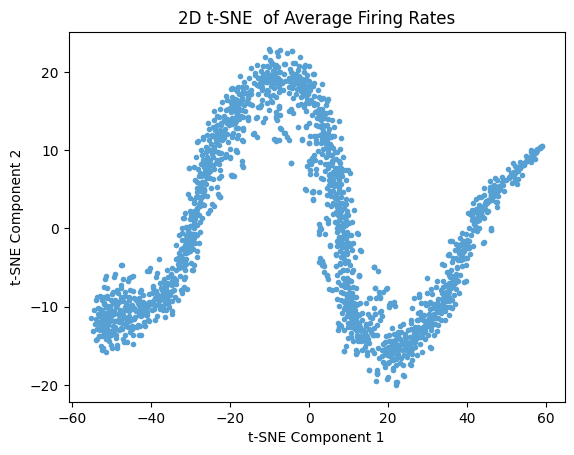

In [54]:
# Define Carolina blue color (in RGB format)
carolina_blue = (86/255, 160/255, 211/255)

# Perform 2D t-SNE. 
tsne_2d = TSNE(n_components=2, random_state=69420)
tsne_2d_results = tsne_2d.fit_transform(avg_firing_rates_df)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE  of Average Firing Rates')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [ ]:
# Perform 3D t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
tsne_3d_results = tsne_3d.fit_transform(avg_firing_rates_df)

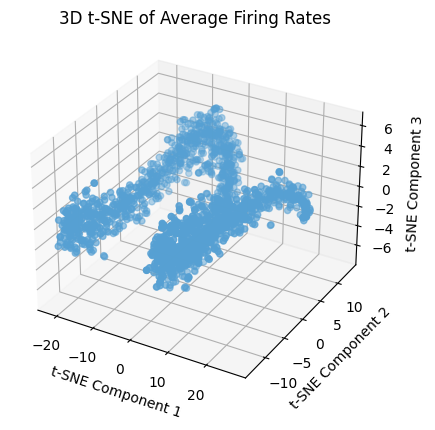

In [53]:
from mpl_toolkits.mplot3d import Axes3D


# Define Carolina blue color (in RGB format)
carolina_blue = (86/255, 160/255, 211/255)

# Plot 3D t-SNE with Carolina blue color
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_3d_results[:, 0], tsne_3d_results[:, 1], tsne_3d_results[:, 2], color=carolina_blue)
ax.set_title('3D t-SNE of Average Firing Rates')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

### Train a basic Neural Net

In [104]:
np.shape(avg_firing_rates_df.values)

array([[15.18748114, 15.50721824, 16.14634449, ..., 15.74670567,
        15.82695438, 18.54471351],
       [ 1.35887992,  0.31973644,  0.399662  , ...,  0.23979754,
         0.47960466,  0.31973644],
       [ 4.955915  ,  4.23650772,  2.95749881, ...,  3.67689575,
         4.955915  ,  4.47631031],
       ...,
       [ 1.35887992,  1.91841865,  1.3588508 , ...,  0.79932516,
         0.47960466,  3.67696923],
       [ 1.59868227,  0.87927523,  2.87756649, ...,  2.23811043,
         2.23815515,  1.11907758],
       [ 3.75690327,  1.83848462,  2.79763392, ...,  1.75851532,
         2.31808919,  2.71775985]])

In [102]:
def train_neural_net(avg_firing_rates_df, split_ratio):
    # Prepare the data.
    X = avg_firing_rates_df.values
    y = avg_firing_rates_df.columns.values.astype(str)

    # Fit a label encoder on the training set and use it to transform both the training and testing sets
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

    # Define the neural network model.
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
    ])

    # Compile the neural network.
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the neural network.
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Test the neural network and compute accuracy.
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy



In [103]:
split_ratio = 0.8
accuracy = train_neural_net(avg_firing_rates_df, split_ratio)
print('Accuracy:', accuracy)


ValueError: Found input variables with inconsistent numbers of samples: [1784, 119]